## pipeline

In [6]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite_w_groupnorm, CellSegNet_basic_edge_gated_VII
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [7]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""
model=CellSegNet_basic_edge_gated_VII(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_HMS_9_batchsize_5.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

# model.eval()
"""
for child in model.children():
    print(child)
    if type(child).__name__.startswith('BatchNorm'):
        child.track_running_stats = False
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#summary(model, (1, 64, 64, 64))

CellSegNet_basic_edge_gated_VII(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): GroupNorm(1, 32, eps=1e-05, affine=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=Tr

### dataset info

In [8]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [9]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [10]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}


In [11]:
# get gt boundary

boundary_gt = np.load(HMS_data_dict_test[case]["boundary"]).astype(float)

feed raw image crops to the model

In [12]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img =\
        semantic_segment_crop_and_cat_3_channel_output(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Time elapsed:  481.82259583473206


4

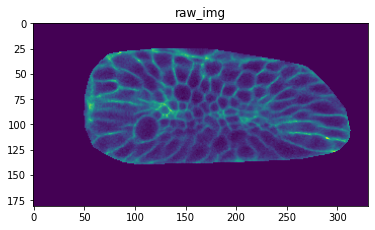

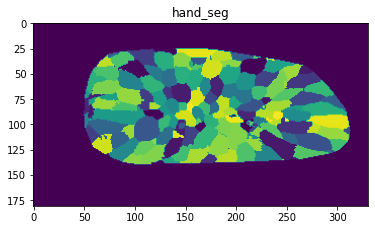

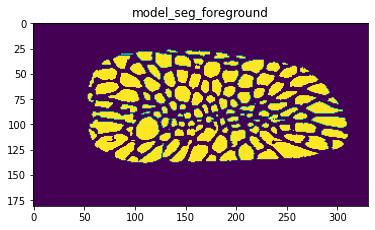

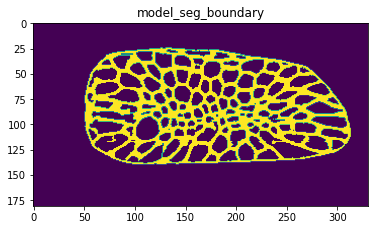

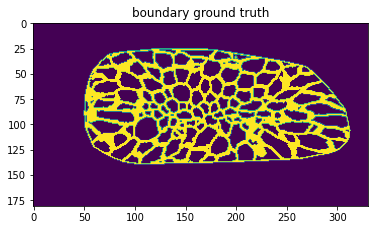

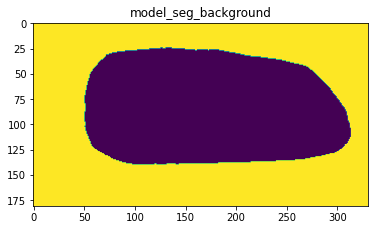

In [13]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[:,:,N])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])
plt.figure()
plt.title("boundary ground truth")
plt.imshow(boundary_gt[:,:,N])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[:,:,N])

TASCAN

generate super vox by watershed

In [14]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

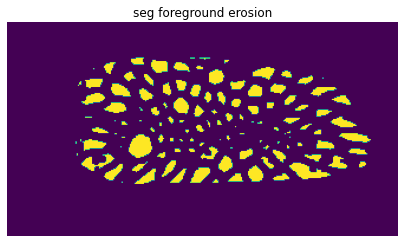

In [15]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground erosion")
plt.axis('off')
plt.imshow(seg_foreground_erosion[:,:,N])

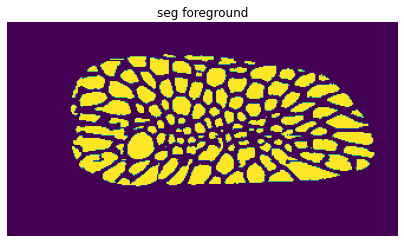

In [16]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])

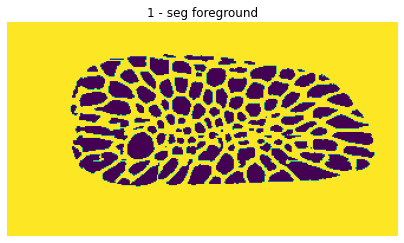

In [17]:
fig = plt.figure(figsize=(7,7))
plt.title("1 - seg foreground")
plt.axis('off')
plt.imshow(1-seg_foreground_comp[:,:,N])

In [18]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 2032 super voxels


super voxel clustearing

In [19]:
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

p_outlayer_area: 597current_crop_outlayer_area: 6current_crop_outlayer_area: 2current_crop_outlayer_area: 19current_crop_outlayer_area: 25current_crop_outlayer_area: 1current_crop_outlayer_area: 27current_crop_outlayer_area: 109current_crop_outlayer_area: 20current_crop_outlayer_area: 32current_crop_outlayer_area: 80current_crop_outlayer_area: 24current_crop_outlayer_area: 0current_crop_outlayer_area: 85current_crop_outlayer_area: 92current_crop_outlayer_area: 40current_crop_outlayer_area: 2current_crop_outlayer_area: 58current_crop_outlayer_area: 45current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 31current_crop_outlayer_area: 0current_crop_outlayer_area: 8current_crop_outlayer_area: 72current_crop_outlayer_area: 83current_crop_outlayer_area: 25current_crop_outlayer_area: 66current_crop_outlayer_area: 23current_crop_outlayer_area: 0current_crop_outlayer_area: 39current_crop_outlayer_area: 25current_crop_outlayer_area: 2current_crop_outlayer_area: 60

delete too small cells

In [20]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [21]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [22]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [23]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

.033898305084745760.050847457627118650.065913370998116750.082862523540489650.10169491525423730.118644067796610170.13747645951035780.156308851224105460.173258003766478350.1920903954802260.209039548022598860.225988700564971750.242937853107344640.26177024482109230.27871939736346520.29755178907721280.31450094161958570.33333333333333330.3521657250470810.36911487758945390.38606403013182670.40489642184557440.42184557438794730.44067796610169490.45762711864406780.47645951035781540.49340866290018830.51035781544256120.5273069679849340.54237288135593220.5593220338983050.57250470809792840.58945386064030140.60451977401129940.62146892655367240.63653483992467040.64971751412429380.66290018832391720.67608286252354040.68926553672316380.70244821092278720.71563088512241060.72881355932203380.74199623352165720.75517890772128060.7683615819209040.78154425612052740.79472693032015060.8079096045197740.82297551789077220.83804143126177020.85310734463276840.8719397363465160.88888888888888880.9039548022598870.9190207

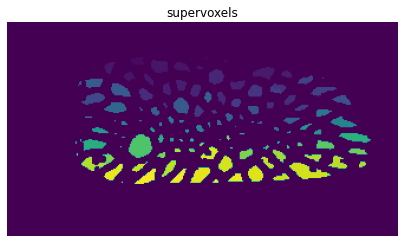

In [24]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

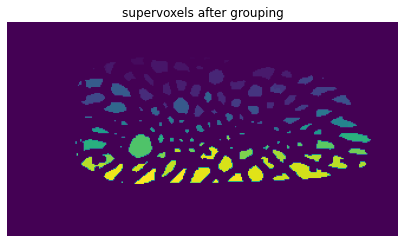

In [25]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels after grouping")
plt.axis('off')
plt.imshow(seg_foreground_single_cell_with_boundary[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

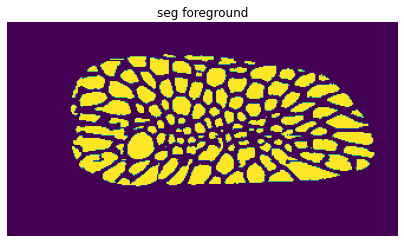

In [26]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

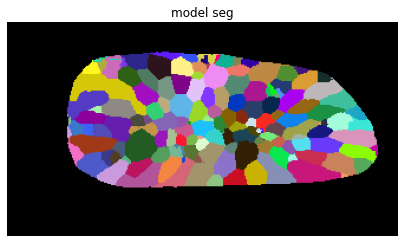

In [27]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

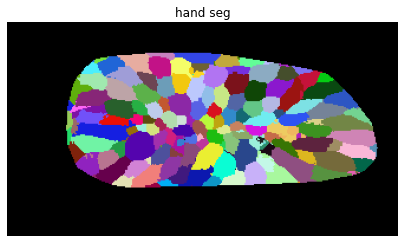

In [28]:
fig = plt.figure(figsize=(7,7))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#,

In [29]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [30]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [31]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.9925404367094158
ARE: (0.36199866507933165, 0.6729753302317298, 0.6064828986556735)
VOI: (1.2076970745850508, 1.2128953382277234)


In [32]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


In [33]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

cell count accuracy iou >0.7: 0.345744680851063861489363%progress: 10.106382978723403%progress: 10.638297872340425%progress: 11.170212765957446%progress: 12.23404255319149%progress: 13.031914893617023%progress: 13.829787234042554%progress: 14.361702127659576%progress: 14.893617021276595%progress: 15.425531914893616%progress: 15.957446808510639%progress: 16.48936170212766%progress: 17.287234042553195%progress: 18.351063829787233%progress: 19.148936170212767%progress: 20.74468085106383%progress: 21.27659574468085%progress: 22.074468085106382%progress: 23.670212765957448%progress: 25.0%progress: 26.063829787234045%progress: 27.127659574468083%progress: 27.659574468085108%progress: 28.98936170212766%progress: 30.0531914893617%progress: 31.382978723404253%progress: 32.97872340425532%progress: 34.57446808510639%progress: 35.90425531914894%progress: 37.234042553191486%progress: 38.03191489361702%progress: 38.82978723404255%progress: 39.8936170212766%progress: 40.691489361702125%progress: 41.7

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/259725777.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/259725777.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

### seg all imgs

In [34]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

def pipeline(raw_img, hand_seg, model, device,
             crop_cube_size, stride,
             how_close_are_the_super_vox_to_boundary=2,
             min_touching_area=30,
             min_touching_percentage=0.51,
             min_cell_size_threshold=1,
             transposes = [[0,1,2]], reverse_transposes = [[0,1,2]]):
    
    seg_final=segment_super_vox_3_channel(raw_img, model, device,
                                          crop_cube_size=crop_cube_size, stride=stride,
                                          how_close_are_the_super_vox_to_boundary=how_close_are_the_super_vox_to_boundary,
                                          min_touching_area=min_touching_area,
                                          min_touching_percentage=min_touching_percentage,
                                          min_cell_size_threshold=min_cell_size_threshold,
                                          transposes = transposes, reverse_transposes = reverse_transposes)
    
    ari = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
    voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))
    
    scale_factor = 0.5
    org_shape = seg_final.shape
    output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
    print(str(org_shape)+" --> "+str(output_size))
    
    accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size),
                                   img_3d_interpolate(seg_final, output_size = output_size))
    accuracy_record=accuracy.cal_accuracy_II()
    hand_seg_after_accuracy=accuracy.gt
    seg_final_after_accuracy=accuracy.pred
    
    return accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final

In [35]:
# mass process
seg_final_dict={}
accuracy_record_dict = {}
ari_dict = {}
voi_dict = {}
for test_file in HMS_data_dict_test.keys():
    print(test_file)
    raw_img=np.load(HMS_data_dict_test[test_file]["raw"])
    hand_seg=np.load(HMS_data_dict_test[test_file]["ins"])
    accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final=\
    pipeline(raw_img, hand_seg, model, device,
             crop_cube_size=64,
             stride=32)
    
    seg_final_dict[test_file] = seg_final
    accuracy_record_dict[test_file] = accuracy_record
    ari_dict[test_file] = ari
    voi_dict[test_file] = voi
    
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Get model semantic seg by combination
996]1193]current_crop_outlayer_area: 2current_crop_outlayer_area: 10current_crop_outlayer_area: 30current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 8current_crop_outlayer_area: 0current_crop_outlayer_area: 5current_crop_outlayer_area: 12current_crop_outlayer_area: 64current_crop_outlayer_area: 16current_crop_outlayer_area: 3current_crop_outlayer_area: 19current_crop_outlayer_area: 22current_crop_outlayer_area: 9current_crop_outlayer_area: 67current_crop_outlayer_area: 36current_crop_outlayer_area: 39current_crop_outlayer_area: 13current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 35current_crop_outlayer_area: 52current_crop_outlayer_area: 2current_crop_outlayer_area: 33current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 23current_crop_outlayer_area: 113current_crop_outlayer_area: 0current_crop_outlayer_area: 72current_crop

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

cell count accuracy iou >0.7: 0.34308510638297873
cell count accuracy dice >0.7: 0.5079787234042553
cell count accuracy iou >0.5: 0.5425531914893617
cell count accuracy dice >0.5: 0.7047872340425532
avg iou: 0.5009164022321396
avg dice: 0.6205423065718818
ari: 0.9925446269105309
voi: (1.2599763296876758, 1.1845187125087073)
----------
120
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Get model semantic seg by combination
t_crop_outlayer_area: 133current_crop_outlayer_area: 57current_crop_outlayer_area: 38current_crop_outlayer_area: 5current_crop_outlayer_area: 0current_crop_outlayer_area: 235current_crop_outlayer_area: 0current_crop_outlayer_area: 23current_crop_outlayer_area: 22current_crop_outlayer_area: 39current_crop_outlayer_area: 91current_crop_outlayer_area: 0current_crop_outlayer_area: 28current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 52current_crop_outlayer_area: 6current_crop_outlayer_area: 9current_crop_outlayer_area: 96current_crop_outlayer_area: 266current_crop_outlayer_area: 10current_crop_outlayer_area: 4current_crop_outlayer_area: 16current_crop_outlayer_area: 46current_crop_outlayer_area: 12current_crop_outlayer_area: 41current_crop_outlayer_area: 6current_crop_outlayer_area: 12current_crop_outlayer_area: 0current_crop_outlayer_area: 78current_crop_outlayer_a

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 4.775280898876404%progress: 5.8988764044943816%progress: 6.460674157303371%progress: 7.584269662921349%progress: 8.426966292134832%progress: 9.831460674157304%progress: 10.955056179775282%progress: 11.797752808988763%progress: 12.921348314606742%progress: 14.606741573033707%progress: 15.44943820224719%progress: 16.573033707865168%progress: 17.415730337078653%progress: 17.97752808988764%progress: 18.820224719101123%progress: 20.224719101123593%progress: 20.786516853932586%progress: 21.629213483146067%progress: 22.191011235955056%progress: 23.03370786516854%progress: 24.15730337078652%progress: 24.719101123595504%progress: 25.56179775280899%progress: 26.40449438202247%progress: 27.247191011235955%progress: 27.808988764044944%progress: 28.370786516853936%progress: 28.932584269662918%progress: 29.49438202247191%progress: 30.0561797752809%progress: 30.61797752808989%progress: 31.46067415730337%progress: 32.02247191011236%progress: 33.14606741573033

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

cell count accuracy iou >0.7: 0.40168539325842695
cell count accuracy dice >0.7: 0.5646067415730337
cell count accuracy iou >0.5: 0.5926966292134831
cell count accuracy dice >0.5: 0.7584269662921348
avg iou: 0.5373634905148863
avg dice: 0.6538087845874134
ari: 0.9931305058278068
voi: (1.1272066792575297, 1.1919266488853888)
----------
65
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Get model semantic seg by combination
313]current_crop_outlayer_area: 197current_crop_outlayer_area: 112current_crop_outlayer_area: 73current_crop_outlayer_area: 96current_crop_outlayer_area: 304current_crop_outlayer_area: 44current_crop_outlayer_area: 0current_crop_outlayer_area: 58current_crop_outlayer_area: 21current_crop_outlayer_area: 0current_crop_outlayer_area: 82current_crop_outlayer_area: 0current_crop_outlayer_area: 92current_crop_outlayer_area: 96current_crop_outlayer_area: 54current_crop_outlayer_area: 132current_crop_outlayer_area: 39current_crop_outlayer_area: 71current_crop_outlayer_area: 0current_crop_outlayer_area: 37current_crop_outlayer_area: 67current_crop_outlayer_area: 20current_crop_outlayer_area: 15current_crop_outlayer_area: 88current_crop_outlayer_area: 28current_crop_outlayer_area: 47current_crop_outlayer_area: 99current_crop_outlayer_area: 74current_crop_outlayer_area: 37current_crop_outlayer_area: 67current_crop_outlayer_area: 8curre

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

cell count accuracy iou >0.7: 0.33881578947368424
cell count accuracy dice >0.7: 0.48026315789473684
cell count accuracy iou >0.5: 0.5131578947368421
cell count accuracy dice >0.5: 0.7335526315789473
avg iou: 0.5199147530633796
avg dice: 0.64423302722188
ari: 0.9938082684138588
voi: (1.1578358849574704, 1.2511647134329005)
----------
90
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Get model semantic seg by combination
431 1447]tlayer_area: 399current_crop_outlayer_area: 14current_crop_outlayer_area: 69current_crop_outlayer_area: 41current_crop_outlayer_area: 37current_crop_outlayer_area: 126current_crop_outlayer_area: 33current_crop_outlayer_area: 24current_crop_outlayer_area: 4current_crop_outlayer_area: 3current_crop_outlayer_area: 0current_crop_outlayer_area: 24current_crop_outlayer_area: 57current_crop_outlayer_area: 3current_crop_outlayer_area: 117current_crop_outlayer_area: 82current_crop_outlayer_area: 80current_crop_outlayer_area: 6current_crop_outlayer_area: 42current_crop_outlayer_area: 33current_crop_outlayer_area: 8current_crop_outlayer_area: 0current_crop_outlayer_area: 12current_crop_outlayer_area: 0current_crop_outlayer_area: 127current_crop_outlayer_area: 4current_crop_outlayer_area: 166current_crop_outlayer_area: 9current_crop_outlayer_area: 34current_crop_outlayer_area: 91current_crop_outlayer_area: 117current_crop_outla

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.3333333333333333
cell count accuracy dice >0.7: 0.45098039215686275
cell count accuracy iou >0.5: 0.4789915966386555
cell count accuracy dice >0.5: 0.6386554621848739
avg iou: 0.4722254155471097
avg dice: 0.5844165516817676
ari: 0.9945150199213395
voi: (1.0910790741711085, 1.308775993539962)
----------


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

In [36]:
for item in seg_final_dict.keys():
    print(item)
    accuracy_record = accuracy_record_dict[item]
    ari = ari_dict[item]
    voi = voi_dict[item]
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")




135
cell count accuracy iou >0.7: 0.34308510638297873
cell count accuracy dice >0.7: 0.5079787234042553
cell count accuracy iou >0.5: 0.5425531914893617
cell count accuracy dice >0.5: 0.7047872340425532
avg iou: 0.5009164022321396
avg dice: 0.6205423065718818
ari: 0.9925446269105309
voi: (1.2599763296876758, 1.1845187125087073)
----------
120
cell count accuracy iou >0.7: 0.40168539325842695
cell count accuracy dice >0.7: 0.5646067415730337
cell count accuracy iou >0.5: 0.5926966292134831
cell count accuracy dice >0.5: 0.7584269662921348
avg iou: 0.5373634905148863
avg dice: 0.6538087845874134
ari: 0.9931305058278068
voi: (1.1272066792575297, 1.1919266488853888)
----------
65
cell count accuracy iou >0.7: 0.33881578947368424
cell count accuracy dice >0.7: 0.48026315789473684
cell count accuracy iou >0.5: 0.5131578947368421
cell count accuracy dice >0.5: 0.7335526315789473
avg iou: 0.5199147530633796
avg dice: 0.64423302722188
ari: 0.9938082684138588
voi: (1.1578358849574704, 1.25116471

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/583679840.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_12994/583679840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

In [37]:
# see the difference for supervoxels

how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

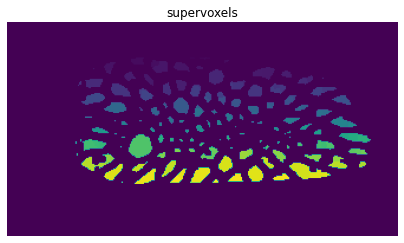

In [38]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
